In [1]:
from embedding_as_service.text.encode import Encoder
import pandas as pd
import sys
sys.path.insert(0, '../code/')
import config
import fetch_data

# Create dataset
df = fetch_data.create_dataset(config.TERMS, config.RETMAX)

Creating empty dataframe into which results will be collected...
Iterating over search terms and collect results into pandas dataframe...
Performing esearch...
Building query for ESearch...
Performing efetch...
Parsing QueryKey (this is required to build the query)...
Parsing WebEnv (this is required to build the query)...
Building query for EFetch...
Performing esearch...
Building query for ESearch...
Performing efetch...
Parsing QueryKey (this is required to build the query)...
Parsing WebEnv (this is required to build the query)...
Building query for EFetch...
Performing esearch...
Building query for ESearch...
Performing efetch...
Parsing QueryKey (this is required to build the query)...
Parsing WebEnv (this is required to build the query)...
Building query for EFetch...
Performing esearch...
Building query for ESearch...
Performing efetch...
Parsing QueryKey (this is required to build the query)...
Parsing WebEnv (this is required to build the query)...
Building query for EFetch..

In [2]:
# Load dataset
df = pd.read_csv('../data/data.csv')

In [49]:
# Calculate word count of abstracts
df['word_count'] = df.abstract.apply(lambda x: len(str(x).split()))

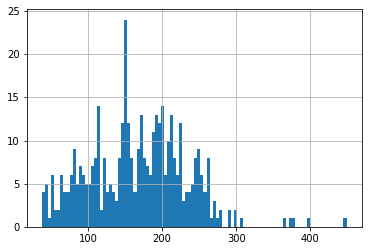

In [51]:
# Adjust max_seq_length of encoder based on word count
_ = df['word_count'].hist(bins=100)

In [4]:
# Initialize encoder
en = Encoder(embedding='albert', model='albert_base', max_seq_length=256)


Loading Model (this might take few minutes).....

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore



INFO:tensorflow:loading sentence piece model
Model loaded Successfully !


Converting texts to features: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [5]:
# Create embeddings
embeddings = en.encode(texts=df['abstract'].tolist(), pooling='reduce_mean')

Converting texts to features: 100%|█████████████████████████████████████████████████| 160/160 [00:00<00:00, 368.67it/s]


In [6]:
# Put embeddings into a dataframe
embeddings = pd.DataFrame(embeddings)

In [7]:
df.tail()

abstract              label
411  Lexical access in bilinguals can be modulated ...  psycholinguistics
412  When spoken language (unimodal) bilinguals swi...  psycholinguistics
413  Two experiments are reported to investigate wh...  psycholinguistics
414  Potential differences in word and speaker reco...  psycholinguistics
415  Attribute-framing bias (AFB) refers to bias in...  psycholinguistics

In [8]:
df.shape

(416, 2)

In [9]:
# Join data
data = embeddings.join(df)

In [48]:
# Export embedded data
data.to_csv('../data/data_embedded.csv', index=False)

In [47]:
data.head()

0         1         2         3         4         5         6  \
0 -0.038224 -0.067237 -0.462501 -0.507530 -0.104026  0.082530 -0.051638   
1 -0.031574 -0.135273 -0.084819 -0.523749  0.160577  0.155008  0.172568   
2 -0.014278  0.199888  0.039885 -0.423313  0.018662  0.105658 -0.370880   
3 -0.063753  0.110764 -0.345702 -0.648752  0.082670  0.053666  0.043596   
4 -0.226208 -0.032611 -0.294303 -0.550147  0.023327  0.201007  0.305101   

          7         8         9  ...       760       761       762       763  \
0 -0.185922 -0.002383  0.410415  ...  0.264452 -0.389501  0.352692  0.245903   
1 -0.078923  0.135841  0.480356  ...  0.174864 -0.431133  0.404933 -0.221600   
2 -0.587095 -0.062548  0.272263  ... -0.012068 -0.442237  0.323007  0.044936   
3  0.167068  0.211376  0.464433  ...  0.145653 -0.368810  0.139389 -0.145733   
4  0.052089  0.094068  0.564281  ...  0.090237 -0.430952  0.014892  0.035739   

        764       765       766       767  \
0 -0.008162  0.105286  0.622623 -0.401972   
1 -0.248984 -0.128524  0.649209 -0.099995   
2 -0.137499 -0.171878  0.295854 -0.310770   
3 -0.064401 -0.107122  0.443956 -0.114751   
4 -0.294225 -0.076284  0.355609 -0.066852   

                                            abstract                     label  
0  Alström syndrome is a rare autosomal recessive...  congenital_abnormalities  
1  In cases of adult acquired flatfoot associated...  congenital_abnormalities  
2  Cleft foot or ectrodactyly is a rare congenita...  congenital_abnormalities  
3  A 63-yr-old black female, with a 1-yr history ...  congenital_abnormalities  
4  Pulmonary arterial hypertension (PAH) commonly...  congenital_abnormalities  

[5 rows x 770 columns]

### Perform PCA on embeddings before tSNE

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(embeddings)
embeddings_pca_transformed = pca.transform(embeddings)

### Perform tSNE on reduced data in 3D

In [45]:
from sklearn.manifold import TSNE
import plotly.express as px

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=5000, perplexity=30)
X_tsne_3D = tsne.fit_transform(embeddings_pca_transformed)

reduced_data = pd.DataFrame(X_tsne_3D, columns = ['dimension_1', 'dimension_2', 'dimension_3'])

sample_data = data.copy()

sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter_3d(sample_data, x='dimension_1', y='dimension_2', z='dimension_3', symbol='label', color='label', opacity=0.7)
fig.show()

### Perform tSNE on reduced data in 2D

In [46]:
# Calculate and draw 2D tSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=5000, perplexity=30)
X_tsne_2D = tsne.fit_transform(embeddings_pca_transformed)

reduced_data = pd.DataFrame(X_tsne_2D, columns = ['Dimension 1', 'Dimension 2'])

sample_data = data.copy()
sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter(sample_data, x='Dimension 1', y='Dimension 2', color='label')
fig.show()

### Experimenting with different perplexities

In [21]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=5000, perplexity=5)
X_tsne_2D = tsne.fit_transform(embeddings)

reduced_data = pd.DataFrame(X_tsne_2D, columns = ['Dimension 1', 'Dimension 2'])

sample_data = data.copy()
sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter(sample_data, x='Dimension 1', y='Dimension 2', color='label')
fig.show()

Computing t-SNE embedding


In [22]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=5000, perplexity=30)
X_tsne_2D = tsne.fit_transform(embeddings)

reduced_data = pd.DataFrame(X_tsne_2D, columns = ['Dimension 1', 'Dimension 2'])

sample_data = data.copy()
sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter(sample_data, x='Dimension 1', y='Dimension 2', color='label')
fig.show()

Computing t-SNE embedding


In [23]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=5000, perplexity=50)
X_tsne_2D = tsne.fit_transform(embeddings)

reduced_data = pd.DataFrame(X_tsne_2D, columns = ['Dimension 1', 'Dimension 2'])

sample_data = data.copy()
sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter(sample_data, x='Dimension 1', y='Dimension 2', color='label')
fig.show()

Computing t-SNE embedding


In [24]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=5000, perplexity=100)
X_tsne_2D = tsne.fit_transform(embeddings)

reduced_data = pd.DataFrame(X_tsne_2D, columns = ['Dimension 1', 'Dimension 2'])

sample_data = data.copy()
sample_data.reset_index(inplace=True)

sample_data = sample_data.join(reduced_data)

fig = px.scatter(sample_data, x='Dimension 1', y='Dimension 2', color='label')
fig.show()

Computing t-SNE embedding
